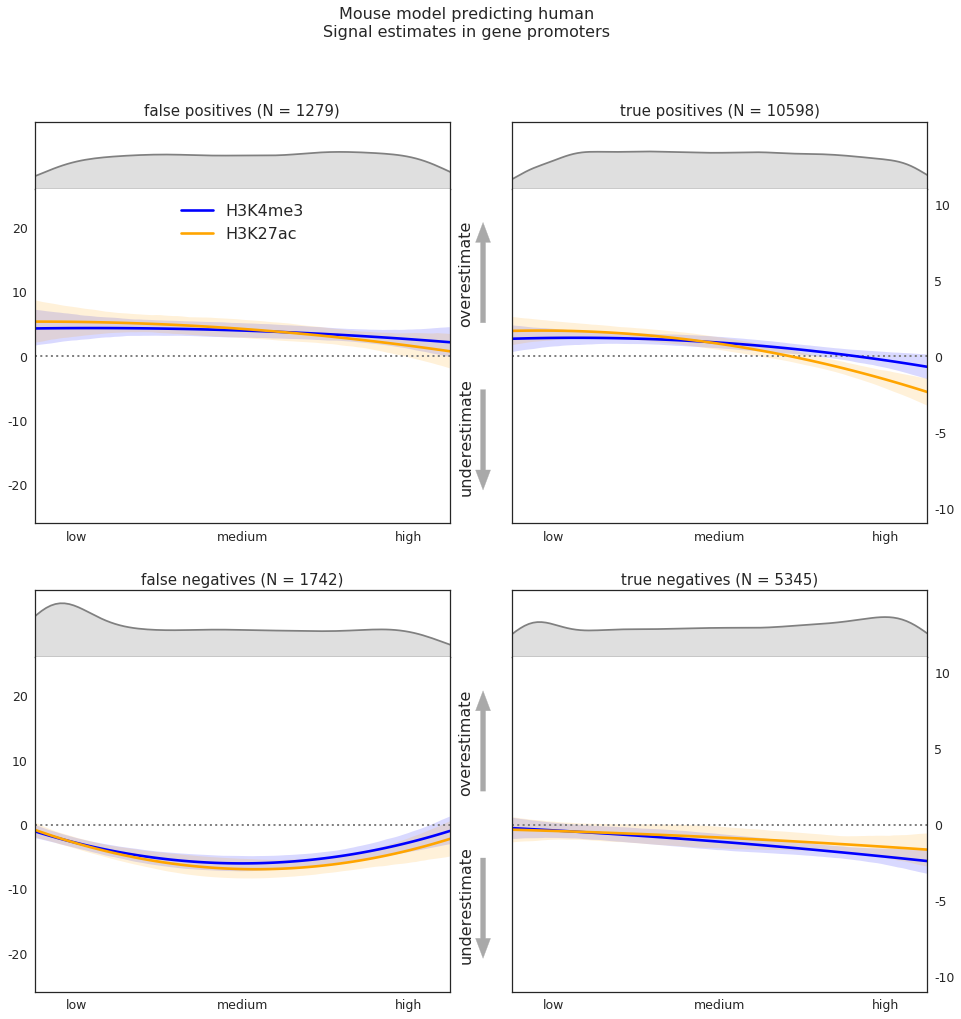

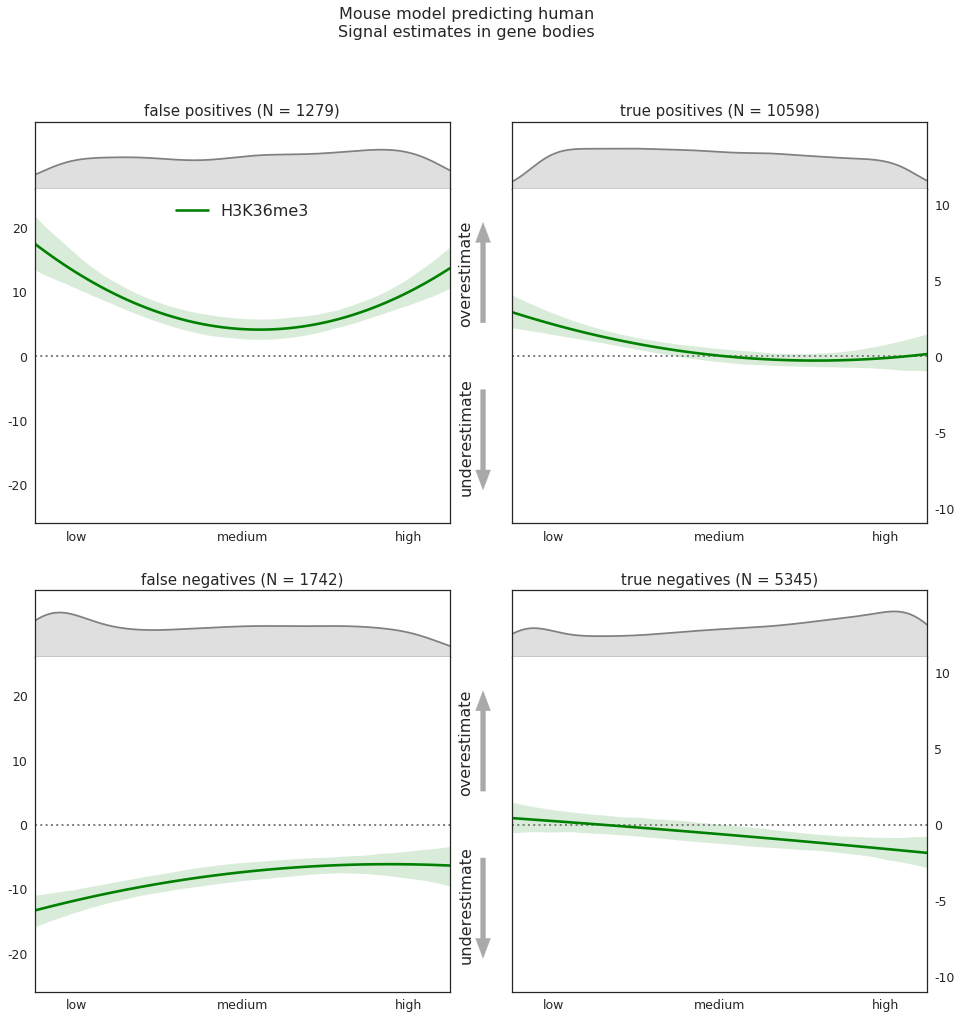

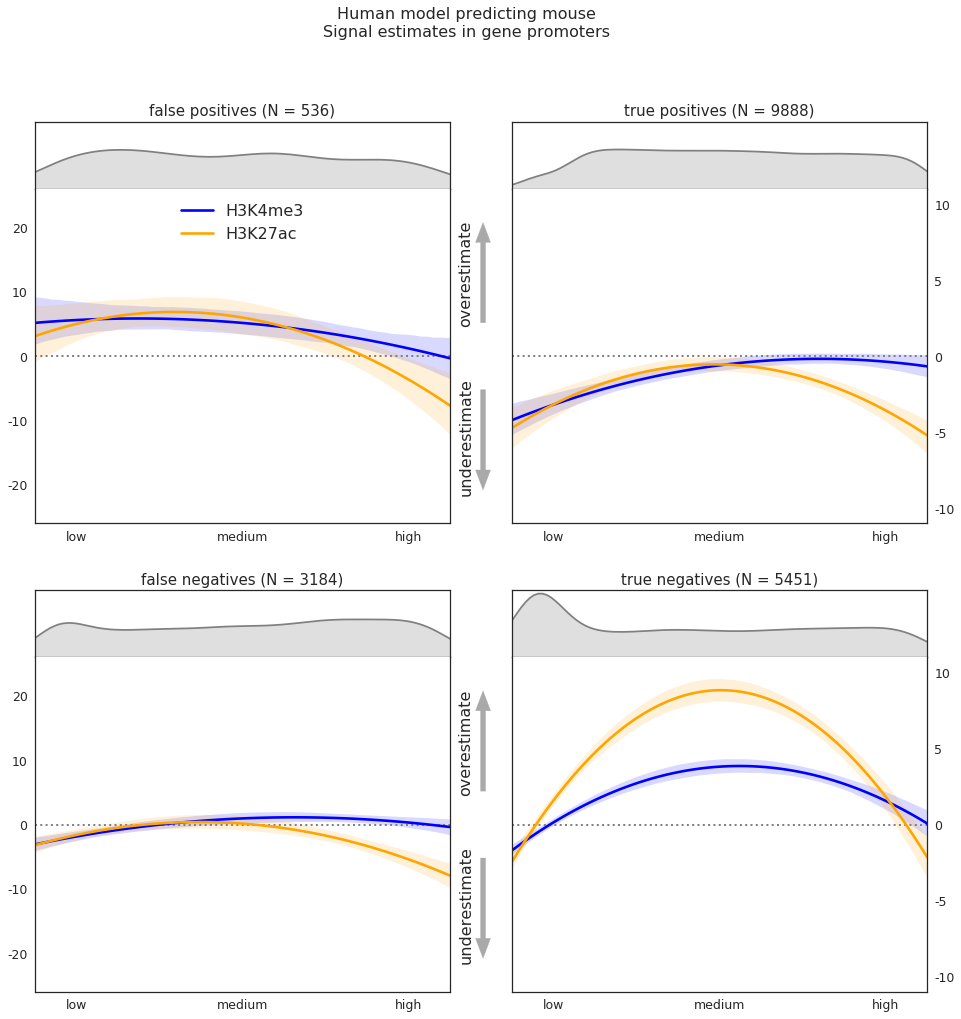

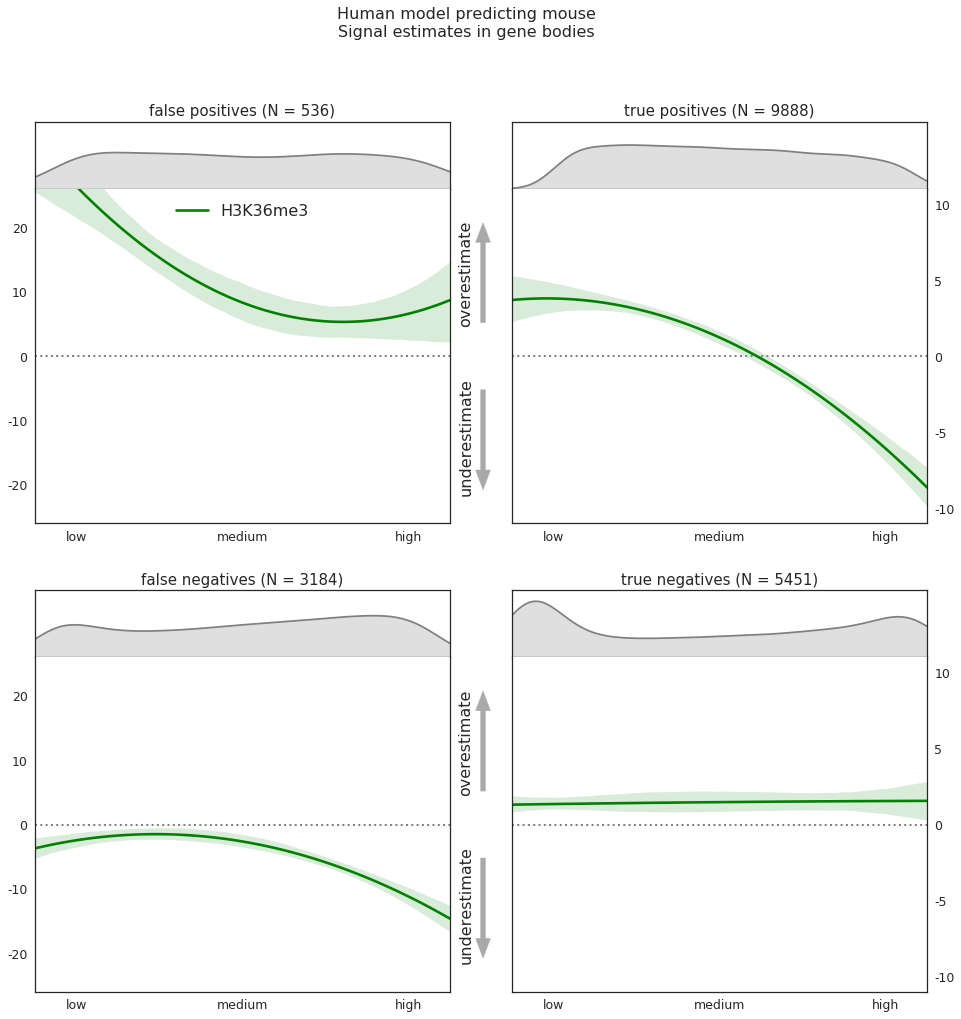

Done


In [1]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_6species.h5')

score_folder = os.path.join(fhgfs_base, 'refdata/conservation/phylop/scores')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

show_figures = True


out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_gene_cons():
    cache_data = os.path.join(cache_dir, 'plot_gene_cons_categ.h5')
    datamatch = 'pos'
    fullmodel = 'can'
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = []
        with pd.HDFStore(cache_data, 'r') as hdf:
            model_perf.append(('human', hdf['perf/human']))
            model_perf.append(('mouse', hdf['perf/mouse']))
            train_hsa = hdf['train/human']
            train_mmu = hdf['train/mouse']
            test_hsa = hdf['test/human']
            test_mmu = hdf['test/mouse']
    else:
        model_perf = dict()
        for spec in ['human', 'mouse']:
            outcomes = dict()
            for outcome in ['tp', 'tn', 'fp', 'fn']:
                outcomes[outcome] = col.Counter()
            model_perf[spec] = outcomes
        model_perf = collect_model_stat_perf(stat_file, model_perf, datamatch, fullmodel)
        print('Writing cache file for gene categorization')
        with pd.HDFStore(cache_data, 'w', complib='blosc') as hdf:
            hdf.put('perf/{}'.format(model_perf[0][0]), model_perf[0][1], format='table')
            hdf.put('perf/{}'.format(model_perf[1][0]), model_perf[1][1], format='table')

            train_path_hsa = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_traindata_exp/train_datasets/hg19_to_mm9')
            train_hsa = collect_feature_data(train_path_hsa)
            hdf.put('train/human', train_hsa, format='table')
            
            train_path_mmu = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_traindata_exp/train_datasets/mm9_to_hg19')
            train_mmu = collect_feature_data(train_path_mmu)
            hdf.put('train/mouse', train_mmu, format='table')

            test_path_hsa = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_testdata_exp/test_datasets/hg19_from_mm9')
            test_hsa = collect_feature_data(test_path_hsa)
            hdf.put('test/human', test_hsa, format='table')

            test_path_mmu = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_testdata_exp/test_datasets/mm9_from_hg19')
            test_mmu = collect_feature_data(test_path_mmu)
            hdf.put('test/mouse', test_mmu, format='table')
    for species, perf in model_perf:
        if species == 'human':
            # reference mouse, query human
            true_data = train_hsa
            est_data = test_hsa
            plot_title = 'Mouse model predicting human\nSignal estimates in gene {}'
        else:
            # reference human, query mouse
            true_data = train_mmu
            est_data = test_mmu
            plot_title = 'Human model predicting mouse\nSignal estimates in gene {}'
            
        fig, exart = plot_feat_dist(species, perf, true_data, est_data, 'reg5p', plot_title.format('promoters'))
        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_qry-{}_sigest_prom.svg'.format(species))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        fig, exart = plot_feat_dist(species, perf, true_data, est_data, 'body', plot_title.format('bodies'))
        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_qry-{}_sigest_body.svg'.format(species))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
    return True


def plot_feat_dist(spec, perf, true_data, est_data, region, figtitle):
    """
    """
    subset = {(0, 0): 'fp', (0, 1): 'tp', (1, 0): 'fn', (1, 1): 'tn'}
    subtitles = {'fp': 'false positives (N = {})', 'tp': 'true positives (N = {})',
                 'fn': 'false negatives (N = {})', 'tn': 'true negatives (N = {})'}
    plot_data = build_plot_dataset(true_data, est_data, perf, region)
    
#     fig, ax = plt.subplots(figsize=(16, 16), sharex=False,
#                            sharey=False, gridspec_kw={'nrows': 8, 'ncols': 2})
    fig, ax = plt.subplots(figsize=(16, 16), sharex=False)
    extra_artists = [fig.suptitle(figtitle, fontsize=16)]
    gs = plt.GridSpec(13, 2)
    default_hspace = gs.get_subplot_params(fig=fig).hspace
    for tup in zip(['fp', 'tp', 'fp', 'tp',
                    'fn', 'tn', 'fn', 'tn'],
                   [(0, 0), (0, 1), (slice(1,6), 0), (slice(1,6), 1),
                    (7, 0), (7, 1), (slice(8,14), 0), (slice(8,14), 1)],
                   ['density', 'density', 'trend', 'trend',
                    'density', 'density', 'trend', 'trend']):
        sub, coords, pltype = tup
        this_axis = plt.subplot(gs[coords[0], coords[1]])
        this_subset = plot_data.loc[plot_data[sub] == 1, :]
        num_genes = this_subset.shape[0]
        if pltype == 'density':
            this_axis.set_xlim(0, 1)
            this_axis.set_ylim(0, 2)
            this_axis.set_title(subtitles[sub].format(num_genes))
            this_axis.set_xticks([])
            this_axis.set_yticks([])
        else:
            this_axis.set_xlim(0, 1)
            this_axis.xaxis.set_ticks([0.1, 0.5, 0.9])
            this_axis.xaxis.set_ticklabels(['low', 'medium', 'high'])
            if sub in ['tp', 'tn']:
                this_axis.set_ylim(-2.2, 2.2)
                #'set_ticklabels', 'set_ticks'
                yticks = [-2, -1, 0, 1, 2]
                this_axis.yaxis.set_ticks(yticks)
                this_axis.yaxis.set_ticklabels(list(map(str, [int(x * 5) for x in yticks])))
                this_axis.yaxis.tick_right()
                
                this_axis.annotate('', xy=(-0.07, 0.1), xytext=(-0.07, 0.4),
                                   xycoords='axes fraction',
                                   arrowprops={'width': 5,
                                               'headwidth': 15,
                                               'headlength': 20,
                                               'color': 'darkgrey'})
                
                this_axis.text(x=-0.13, y=0.4 , s='underestimate', rotation='vertical',
                               fontsize=16,
                               transform=this_axis.transAxes)
                
                this_axis.annotate('', xy=(-0.07, 0.9), xytext=(-0.07, 0.6),
                                   xycoords='axes fraction',
                                   arrowprops={'width': 5,
                                               'headwidth': 15,
                                               'headlength': 20,
                                               'color': 'darkgrey'})
                
                this_axis.text(x=-0.13, y=0.87 , s='overestimate', rotation='vertical',
                               fontsize=16,
                               transform=this_axis.transAxes)
                
            else:
                this_axis.set_ylim(-5.2, 5.2)
                yticks = [-4, -2, 0, 2, 4]
                this_axis.yaxis.set_ticks(yticks)
                this_axis.yaxis.set_ticklabels(list(map(str, [int(x * 5) for x in yticks])))
            this_axis.spines['top'].set_visible(False)
        if region == 'reg5p':
            if pltype == 'density':
                sns.kdeplot(this_subset['xloc'].values, ax=this_axis, shade=True,
                            color='grey', cumulative=False)
            else:
                this_axis.axhline(y=0, lw=2, color='grey', ls='dotted', zorder=1)

                sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K4me3'].values, ci=95,
                            ax=this_axis, color='blue', label='H3K4me3', order=2, scatter=False)
                sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K27ac'].values, ci=95,
                            ax=this_axis, color='orange', label='H3K27ac', order=2, scatter=False)
        else:
            if pltype == 'density':
                sns.kdeplot(this_subset['xloc'].values, ax=this_axis, shade=True,
                            color='grey', cumulative=False)
            else:
                this_axis.axhline(y=0, lw=2, color='grey', ls='dotted', zorder=1)
                sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K36me3'].values, ci=95,
                            ax=this_axis, color='green', label='H3K36me3', order=2, scatter=False)
        if sub == 'fp' and pltype == 'trend':
            this_axis.legend(loc='upper center', fontsize=16)
        # adjust space between subplots
        if sub in ['tp', 'fp'] and pltype == 'density':
            gs.update(hspace=0.001, wspace=0.15)
        elif sub in ['tp', 'fp'] and pltype == 'trend':
            gs.update(hspace=default_hspace, wspace=0.15)
        elif sub in ['fn', 'tn'] and pltype == 'density':
            gs.update(hspace=0.001, wspace=0.15)
        else:
            pass
    if show_figures:  
        plt.show()
    return fig, extra_artists

# def plot_feat_dist_simple(spec, perf, true_data, est_data, region):
#     """
#     """
#     fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
#     subset = {(0, 0): 'fp', (0, 1): 'tp', (1, 0): 'fn', (1, 1): 'tn'}
#     subtitles = {(0, 0): 'false positives', (0, 1): 'true positives',
#                  (1, 0): 'false negatives', (1, 1): 'true negatives'}
#     plot_data = build_plot_dataset(true_data, est_data, perf, region)
    
#     for i in range(2):
        
#         for j in range(2):
            
#             this_axis = ax[i, j]
#             this_axis.set_xlim(-0.01, 1.01)
#             this_axis.set_ylim(-2, 2)
#             this_axis.set_title(subtitles[(i, j)])
#             select = subset[(i, j)]
#             this_subset = plot_data.loc[plot_data[select] == 1, :]
#             num_genes = this_subset.shape[0]
#             if region == 'reg5p':
#                 this_axis.axhline(y=0, lw=2, color='grey', ls='dotted', zorder=1)

#                 sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K4me3'].values, ci=95,
#                             ax=this_axis, color='blue', label='H3K4me3', order=2, scatter=False)
#                 sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K27ac'].values, ci=95,
#                             ax=this_axis, color='orange', label='H3K27ac', order=2, scatter=False)
#             else:
#                 this_axis.axhline(y=0, lw=2, color='grey', ls='dotted', zorder=1)
#                 #this_axis.scatter(this_subset['xloc'].values, this_subset['yloc_H3K36me3'].values,
#                 #                  c='green', label='H3K36me3')
#                 sns.regplot(this_subset['xloc'].values, this_subset['yloc_H3K36me3'].values, ci=95,
#                             ax=this_axis, color='green', label='H3K36me3', order=2, scatter=False)
#     plt.show()
#     raise
#     return fig, []
                
            
            

def build_plot_dataset(true_data, est_data, perf_data, region):
    true_data.index = true_data['name']
    est_data.index = est_data['name']
    if region == 'reg5p':
        plot_data = pd.DataFrame(np.zeros((true_data.shape[0], 3), dtype=np.float32),
                                 columns=['xloc', 'yloc_H3K4me3', 'yloc_H3K27ac'],
                                 index=true_data['name'])
        cons_reg5p = [c for c in true_data.columns if c.endswith('consrnk_reg5p')]
        xlocs = pd.Series(true_data.loc[:, cons_reg5p].mean(axis=1))
        assert xlocs.index.isin(plot_data.index).all(), 'Index mismatch'
        plot_data['xloc'] = xlocs
        for m in ['H3K4me3', 'H3K27ac']:
            cols = [c for c in true_data.columns if m in c and c.endswith('sigrnk_reg5p')]
            avg_true = true_data.loc[:, cols].mean(axis=1)
            avg_est = est_data.loc[:, cols].mean(axis=1)
            step_diff = (avg_est - avg_true).div(0.05)
            assert step_diff.max() <= 20 and step_diff.min() >= -20, 'Step diff wrong'
            plot_data['yloc_{}'.format(m)] = step_diff
        plot_data = pd.concat([plot_data, perf_data.loc[:, ['tp', 'tn', 'fp', 'fn']].copy()],
                              ignore_index=False, axis=1)
    elif region == 'body':
        plot_data = pd.DataFrame(np.zeros((true_data.shape[0], 2), dtype=np.float32),
                                 columns=['xloc', 'yloc_H3K36me3'],
                                 index=true_data['name'])
        cons_body = [c for c in true_data.columns if c.endswith('consrnk_body')]
        xlocs = pd.Series(true_data.loc[:, cons_body].mean(axis=1))
        assert xlocs.index.isin(plot_data.index).all(), 'Index mismatch'
        plot_data['xloc'] = xlocs
        cols = [c for c in true_data.columns if 'H3K36me3' in c and c.endswith('sigrnk_body')]
        avg_true = true_data.loc[:, cols].mean(axis=1)
        avg_est = est_data.loc[:, cols].mean(axis=1)
        step_diff = (avg_est - avg_true).div(0.05)
        assert step_diff.max() <= 20 and step_diff.min() >= -20, 'Step diff wrong'
        plot_data['yloc_H3K36me3'] = step_diff
        plot_data = pd.concat([plot_data, perf_data.loc[:, ['tp', 'tn', 'fp', 'fn']].copy()],
                              ignore_index=False, axis=1)
    else:
        ValueError(region)
    return plot_data

FEAT_COLS = ['ftmsig_H3K36me3_abs_mean_body',
            'ftmsig_H3K4me3_abs_mean_reg5p',
            'ftmsig_H3K27ac_abs_mean_reg5p',
            'ftmsig_H3K4me3_pct_cons_reg5p',
            'ftmsig_H3K27ac_pct_cons_reg5p',
            'ftmsig_H3K36me3_pct_cons_body',
            'end_body',
            'start_body',
            'end_reg5p',
            'start_reg5p',
            'name',
            'symbol']

MERGE_COLS = ['name', 'symbol', 'end_body', 'start_body', 'end_reg5p', 'start_reg5p']


def rename_columns(cols, data_id, tissue):
    new_cols = []
    for c in cols:
        if c.startswith('ft'):
            infix = 'sig' if 'mean' in c else 'cons'
            parts = c.split('_')
            new_col = '_'.join([data_id, tissue, parts[1], infix , parts[-1]])
            new_cols.append(new_col)
        else:
            new_cols.append(c)
    return new_cols


def collect_feature_data(path):
    feat_files = os.listdir(path)
    feat_files = [f for f in feat_files if f.endswith('.feat.h5')]
    done = set()
    full_dataset = None
    for f in feat_files:
        if any([c in f for c in ['GM12878', 'CH12', 'K562', 'MEL', 'kidney', 'brain']]):
                continue
        dataset = f.split('.')[0]
        parts = dataset.split('_')
        data_id, tissue = parts[1], parts[-1]
        if data_id in done:
            continue
        done.add(data_id)
        fpath = os.path.join(path, f)
        data = []
        with pd.HDFStore(fpath, 'r') as hdf:
            for k in hdf.keys():
                if k != '/metadata':
                    sub = hdf[k]
                    sub = sub.loc[:, FEAT_COLS]
                    data.append(sub)
        data = pd.concat(data, axis=0, ignore_index=False, join='outer')
        data.columns = rename_columns(data.columns, data_id, tissue)
        if full_dataset is None:
            full_dataset = data
        else:
            full_dataset = full_dataset.merge(data, how='outer', on=MERGE_COLS)
    # merge replicates
    dup_cols = col.defaultdict(list)
    for c in full_dataset.columns:
        if 'cons' in c or 'sig' in c:
            short_id = c.split('_', 1)[-1]
            dup_cols[short_id].append(c)
    drop_cols = []
    for k, v in dup_cols.items():
        if len(v) > 1:
            avg_col = full_dataset.loc[:, v].mean(axis=1)
            full_dataset[k] = avg_col
            drop_cols.extend(v)
        else:
            drop_cols.extend(v)
            full_dataset[k] = full_dataset[v].copy()
    full_dataset.drop(drop_cols, axis=1, inplace=True)
    # add rank info
    rank_cols = [c for c in full_dataset.columns if 'sig' in c or 'cons' in c]
    for rc in rank_cols:
        if 'sig' in rc:
            rnk_col = rc.replace('sig', 'sigrnk')
            full_dataset[rnk_col] = full_dataset[rc].rank(axis=0, pct=True)
        else:
            rnk_col = rc.replace('cons', 'consrnk')
            full_dataset[rnk_col] = full_dataset[rc].rank(axis=0, pct=True)
    return full_dataset


def collect_model_stat_perf(fpath, data_collect, scenario, model):
    """
    """
    done = set()
    with pd.HDFStore(fpath, 'r') as hdf:
        all_keys = list(hdf.keys())
        filter_hsa = '/'.join(['', scenario, model, 'human', 'mouse'])
        filter_mmu = '/'.join(['', scenario, model, 'mouse', 'human'])
        load_keys = list(filter(lambda x: x.startswith(filter_hsa) or x.startswith(filter_mmu), all_keys))
        load_keys = filter(lambda x: x.endswith('/data'), load_keys)
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL', 'kidney', 'brain']]):
                continue
            data = hdf[k]
            path_comp = k.split('/')
            spec_a, spec_b = path_comp[3], path_comp[4]
            ref_a, qry_b = path_comp[5], path_comp[6]
            if (ref_a, qry_b) in done:
                continue
            else:
                done.add((ref_a, qry_b))
            gene_names = data.index
            
            select = gene_names[np.array(data['tp'].values, dtype=np.bool)].tolist()
            data_collect[spec_b]['tp'].update(select)
            
            select = gene_names[np.array(data['tn'].values, dtype=np.bool)].tolist()
            data_collect[spec_b]['tn'].update(select)
            
            select = gene_names[np.array(data['fp'].values, dtype=np.bool)].tolist()
            data_collect[spec_b]['fp'].update(select)
            
            select = gene_names[np.array(data['fn'].values, dtype=np.bool)].tolist()
            data_collect[spec_b]['fn'].update(select)
            
            if 'cons_score' not in data_collect[spec_b]:
                score = dict()
                rank = dict()
                for g, s, r in zip(data.index.values,
                                   data.loc[:, 'cons_score'].values,
                                   data.loc[:, 'cons_rank'].values):
                    score[g] = s
                    rank[g] = r
                data_collect[spec_b]['cons_score'] = score
                data_collect[spec_b]['cons_rank'] = rank
    # split into two dataframes
    ret_df = []
    for species, data in data_collect.items():
        genes = sorted(data['cons_score'].keys())
        num_genes = len(genes)
        spec_data = pd.DataFrame(np.zeros((num_genes, 10), dtype=np.float32),
                                          index=genes,
                                          columns=['seq_cons_tss', 'seq_consrnk_tss',
                                                  'tp_count', 'tn_count', 'fp_count', 'fn_count',
                                                  'tp', 'tn', 'fp', 'fn'])
        cons = sorted([(k, v) for k, v in data['cons_score'].items()])
        assert len(cons) == len(genes), 'oops'
        spec_data['seq_cons_tss'] = pd.Series([t[1] for t in cons], index=[t[0] for t in cons])
        rank = sorted([(k, v) for k, v in data['cons_rank'].items()])
        assert len(rank) == len(genes), 'oops'
        spec_data['seq_consrnk_tss'] = pd.Series([t[1] for t in rank], index=[t[0] for t in rank])
        for g in genes:
            tp, tn, fp, fn = data['tp'][g], data['tn'][g], data['fp'][g], data['fn'][g]
            spec_data.at[g, 'tp_count'] = tp
            spec_data.at[g, 'tn_count'] = tn
            spec_data.at[g, 'fp_count'] = fp
            spec_data.at[g, 'fn_count'] = fn
            setter = sorted([(tp, 'tp'), (tn, 'tn'), (fp, 'fp'), (fn, 'fn')], reverse=True)
            last_max = 0
            for val, label in setter:
                if val >= last_max and val > 0:
                    last_max = val
                    spec_data.at[g, label] = 1
                else:
                    break
        ret_df.append((species, spec_data))
    return ret_df


execd = exec_gene_cons()
if execd:
    print('Done')
